# **iPSC-derived Hypothalamic Neurons (Example 2)**

- **Data File:**
  - https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE243112
  - https://www.ncbi.nlm.nih.gov/pubmed/38575728
  - GSE243112_RAW.tar (WT samples ONLY; KOLF2.1J iPSC -> Neurons)
- **User Instructions:**
  - Link to Google Drive
  - Modify file paths as needed
- **Steps**
  - Setup
  - Preprocessing
  - CNA Detection Pipeline
  - Visualization of Results
  - Comparison to Known CNVs

# **Setup**

In [ ]:
!pip install scanpy python-igraph leidenalg scipy umap-learn anndata hmmlearn mygene

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 23.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/CSCB_Final/
%ls

Mounted at /content/drive
/content/drive/My Drive/CSCB_Final
 cna_heatmap.png                        'Paper Draft.gdoc'
 cna_task3_test3_embryoids_heatmap.png  'Presentation Draft.gslides'
 Data/                                  'Task 2A'/
 example_package_usage_benchmark         task3_test1_2dGastruloids
 Final_Pipeline.ipynb                    task3_test2_neurons.ipynb
 nikhil_final.ipynb                      task3_test3_embryoid_bodies
'Old Notebooks'/


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
from sklearn.metrics import f1_score
import seaborn as sns
from typing import List, Dict, Optional, Tuple
from scipy.stats import zscore
from scipy.sparse import csr_matrix, issparse
import re
from sklearn.cluster import KMeans
from hmmlearn import hmm
import mygene

In [ ]:
# Base directory
base_dir = "/content/drive/My Drive/CSCB_Final/Data/NeuronData/"

# List of all h5 files with full paths
h5_files = [
    base_dir + "GSM7779476_SLX-21197.SITTA11.filtered_feature_bc_matrix.h5",
    base_dir + "GSM7779477_SLX-21197.SITTB11.filtered_feature_bc_matrix.h5",
    base_dir + "GSM7779478_SLX-21197.SITTF10.filtered_feature_bc_matrix.h5",
    base_dir + "GSM7779479_SLX-22979.SITTD3.filtered_feature_bc_matrix.h5",
    base_dir + "GSM7779480_SLX-22979.SITTH3.filtered_feature_bc_matrix.h5",
    base_dir + "GSM7779481_SLX-22979.SITTH2.filtered_feature_bc_matrix.h5",
]


In [ ]:
# Load each .h5 file and process
adatas = []
for file in h5_files:
  adata = sc.read_10x_h5(file)
  adata.var_names_make_unique()
  adatas.append(adata)

/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1758: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_name

In [ ]:
# Concatenate all AnnData objects into one
adata_combined = ad.concat(adatas)
adata_combined.obs_names_make_unique()
adata_combined.var_names_make_unique()

/usr/local/lib/python3.11/dist-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [ ]:
# Basic data exploration
display(adata_combined.obs)
display(adata_combined.var)
display(adata_combined.X.shape)

""
AAACCCAAGAACTTCC-1
AAACCCAAGGCGTCCT-1
AAACCCACAACCGATT-1
AAACCCACACTGAATC-1
AAACCCACAGCTGAGA-1
...
TTTGTTGCACTGGATT-1
TTTGTTGCAGACGATG-1
TTTGTTGCATGTCTAG-1
TTTGTTGGTGACATCT-1


""
DDX11L1
WASH7P
MIR6859-1
MIR1302-2HG
MIR1302-2
...
MT-ND6
MT-TE
MT-CYB
MT-TT


(39885, 60624)

# **Preprocessing**

In [ ]:
def preprocess_anndata(
    ad,
    mt_filter=True,
    count_filter=True,
    normalize=True,
    use_pcs=True,
    n_pcs=10,
    n_neighbors=20,
    marker_genes_dict=None,
    leiden_resolution=0.1
):
    """
    Run a flexible single-cell RNA-seq analysis pipeline with optional QC, normalization, clustering, and plotting.

    Parameters:
    - ad (AnnData): Input AnnData object.
    - mt_filter (bool): Whether to filter cells with high mitochondrial percentage.
    - count_filter (bool): Whether to filter cells with too few genes or too many counts.
    - normalize (bool): Whether to normalize and log-transform expression values.
    - use_pcs (bool): Whether to use PCA for kNN graph construction.
    - n_pcs (int): Number of principal components.
    - n_neighbors (int): Number of neighbors for graph construction.
    - marker_genes_dict (dict): Dictionary of marker genes by cell type for plotting.
    - leiden_resolution (float): Resolution parameter for Leiden clustering.

    Returns:
    - AnnData: Processed and clustered AnnData object.
    """
    print("Step 1: Copying AnnData object...")
    ad_analys = ad.copy()

    print("Step 2: Calculating QC metrics...")
    ad_analys.var['mt'] = ad_analys.var_names.str.upper().str.startswith('MT-')
    sc.pp.calculate_qc_metrics(ad_analys, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

    adClean = ad_analys.copy()
    if mt_filter:
        print("Step 3: Applying mitochondrial filter (<20%)...")
        adClean = adClean[adClean.obs['pct_counts_mt'] < 20].copy()

    if count_filter:
        print("Step 4: Applying cell count filters (min_genes=500, max_counts=30000)...")
        sc.pp.filter_cells(adClean, min_genes=500)
        sc.pp.filter_cells(adClean, max_counts=30000)

    print("Step 5: Filtering genes expressed in at least 3 cells...")
    sc.pp.filter_genes(adClean, min_cells=3)

    print("Step 6: Normalizing data and selecting highly variable genes...")
    adNorm = adClean.copy()
    if normalize:
        sc.pp.normalize_total(adNorm, target_sum=1e4)
        sc.pp.log1p(adNorm)
        sc.pp.highly_variable_genes(adNorm, min_mean=0.0125, max_mean=6, min_disp=0.25)
    else:
        print("Skipping normalization and HVG selection...")

    print("Step 7: Performing PCA...")
    if normalize:
        sc.tl.pca(adNorm, use_highly_variable=True)
    else:
        sc.tl.pca(adNorm)

    print("Step 8: Building neighborhood graph...")
    if use_pcs:
        sc.pp.neighbors(adNorm, n_neighbors=n_neighbors, n_pcs=n_pcs)
    else:
        sc.pp.neighbors(adNorm, n_neighbors=n_neighbors)

    print("Step 9: Running Leiden clustering and UMAP embedding...")
    sc.tl.leiden(adNorm, resolution=leiden_resolution)
    sc.tl.paga(adNorm)
    sc.pl.paga(adNorm, plot=False)
    sc.tl.umap(adNorm, init_pos='paga')

    print("Step 10: Plotting UMAP and Dotplot...")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 5), gridspec_kw={'wspace': 0.4})
    ax1_dict = sc.pl.umap(adNorm, color=['leiden'], alpha=0.75, s=10, legend_loc='on data', ax=ax1, show=False)
    ax2_dict = sc.pl.dotplot(adNorm, marker_genes_dict, 'leiden', dendrogram=True,ax=ax2, show=False)
    plt.show()

    print("Analysis complete.")
    return adNorm



- **Literature for Marker Gene Selection**
  - https://www.nature.com/articles/s41598-018-27293-5

In [ ]:
# matches = [gene for gene in adata_combined.var.index if gene.lower().startswith("CX3CR1".lower())]
# matches

marker_genes = {
    "Neuronal_Progenitor_Cells": ["SOX2", "NES", "PAX6"],
    "Neurons": ["MAP2", "RBFOX3", "TUBB3"],
    "Glial_Cells": ["GFAP", "S100B", "OLIG2"]
}


Step 1: Copying AnnData object...
Step 2: Calculating QC metrics...
Step 3: Applying mitochondrial filter (<20%)...
Step 4: Applying cell count filters (min_genes=500, max_counts=30000)...
Step 5: Filtering genes expressed in at least 3 cells...
Step 6: Normalizing data and selecting highly variable genes...
Step 7: Performing PCA...
Step 8: Building neighborhood graph...
Step 9: Running Leiden clustering and UMAP embedding...
Step 10: Plotting UMAP and Dotplot...
categories: 0, 1, 2, etc.
var_group_labels: Neuronal_Progenitor_Cells, Neurons, Glial_Cells


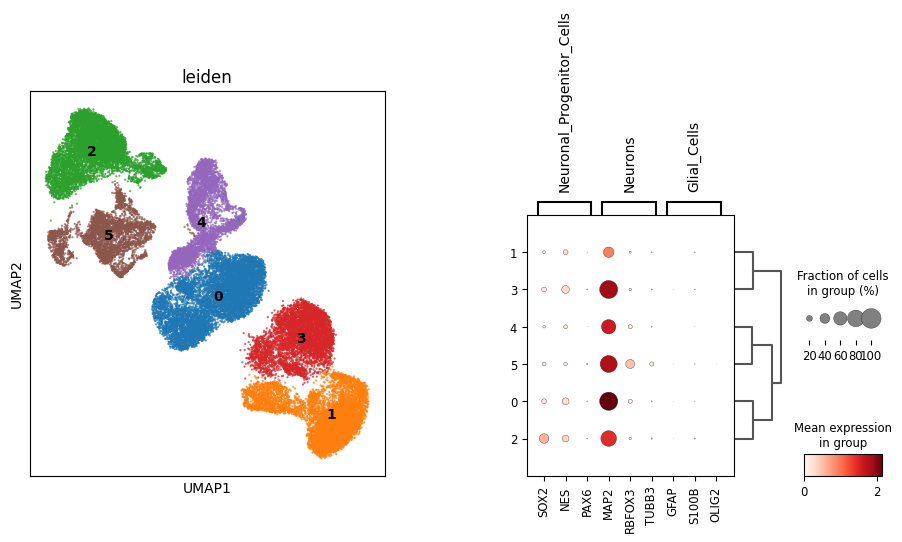

Analysis complete.


In [ ]:
# Run proprocessing function on dataset
adata_neurons = preprocess_anndata(
    ad=adata_combined,
    marker_genes_dict=marker_genes,
    leiden_resolution=0.1,
    n_pcs=15
)

Based on the consistent expression in the above clusters and marker gene expression, we can simply conclude that all the cells to be neurons.

In [ ]:
# Define new combined cell type annotations
cell_dict = {
    'Neuron': ['0','1','2','3','4','5']
  }


# Re-annotate cell types
new_obs_name = 'cell_type'
adata_neurons.obs[new_obs_name] = np.nan
for cell_type, clusters in cell_dict.items():
    ind = adata_neurons.obs['leiden'].isin(clusters)
    adata_neurons.obs.loc[ind, new_obs_name] = cell_type

# Convert to categorical
adata_neurons.obs['cell_type'] = adata_neurons.obs['cell_type'].astype("category")

# Check distribution
print(adata_neurons.obs['cell_type'].value_counts())

cell_type
Neuron    36749
Name: count, dtype: int64


# **CNA Detection Pipeline**

In [ ]:
!pip install git+https://github.com/nik548/cscbfinalprojectS25.git
import genecnv as gcnv

  Cloning https://github.com/nik548/cscbfinalprojectS25.git to /tmp/pip-req-build-9d1fuk_z
  Running command git clone --filter=blob:none --quiet https://github.com/nik548/cscbfinalprojectS25.git /tmp/pip-req-build-9d1fuk_z
  Resolved https://github.com/nik548/cscbfinalprojectS25.git to commit f19f6602d4bcc3dd15285ba2e6ffa85e1ddb340e
  Preparing metadata (setup.py) ... done
  Created wheel for genecnv: filename=genecnv-0.1.0-py3-none-any.whl size=12507 sha256=7726214912d5a88d83862d5689fa52e8aacaefc3cb5f76e19b4fac392050cc3d
  Stored in directory: /tmp/pip-ephem-wheel-cache-g8uc8arf/wheels/07/07/23/7aaef129afafd97bc8ace0b5ef55ed4cbc3756a9e062a9db35
Successfully built genecnv


In [ ]:
# Create copy to run through CNA detection steps
adata_neurons_preprocessed = adata_neurons.copy()

In [ ]:
# Annotate genes if coordinates missing
neurons_annot = gcnv.annotate_genes_mygene(adata_neurons_preprocessed)

INFO:biothings.client:querying 1-1000 ...


Preparing to query 41029 gene identifiers...
Querying MyGene.info for 35811 unique gene identifiers...


INFO:biothings.client:querying 1001-2000 ...
INFO:biothings.client:querying 2001-3000 ...
INFO:biothings.client:querying 3001-4000 ...
INFO:biothings.client:querying 4001-5000 ...
INFO:biothings.client:querying 5001-6000 ...
INFO:biothings.client:querying 6001-7000 ...
INFO:biothings.client:querying 7001-8000 ...
INFO:biothings.client:querying 8001-9000 ...
INFO:biothings.client:querying 9001-10000 ...
INFO:biothings.client:querying 10001-11000 ...
INFO:biothings.client:querying 11001-12000 ...
INFO:biothings.client:querying 12001-13000 ...
INFO:biothings.client:querying 13001-14000 ...
INFO:biothings.client:querying 14001-15000 ...
INFO:biothings.client:querying 15001-16000 ...
INFO:biothings.client:querying 16001-17000 ...
INFO:biothings.client:querying 17001-18000 ...
INFO:biothings.client:querying 18001-19000 ...
INFO:biothings.client:querying 19001-20000 ...
INFO:biothings.client:querying 20001-21000 ...
INFO:biothings.client:querying 21001-22000 ...
INFO:biothings.client:querying

Annotation summary:
  Total genes: 41029
  Successfully annotated: 26021 (63.4%)
  Standard chromosomes (1-22,X,Y): 25631 (62.5%)
Returning filtered AnnData with 25631 genes


In [ ]:
# Run the full CNV pipeline
neurons_annot_with_calls, bins, centers, calls = gcnv.run_adaptive_cnv_pipeline(
    neurons_annot,
    cell_type_key="cell_type",
    target_genes_per_bin=100,
    decay_scale=1e6,
    decay_radius=10,
    reference_frac=0.15,
    min_run=2,
    n_cells=1000
)

In [ ]:
# Annotate .obs of AnnData object with CNA calls
gcnv.annotate_cnv_calls(neurons_annot_with_calls, calls, bins, centers)

In [ ]:
# Now, we can see our CNA call present in the "cnv_regions" column!
neurons_annot_with_calls.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,n_counts,leiden,cell_type,cnv_regions
GACGTTAGTTGGACCC-1,4623,9847.0,156.0,1.584239,4623,9847.0,0,Neuron,"1:14696-4792534 (gain), 1:4973381-11909927 (ga..."
CGGAGAATCCGTGGGT-1,2262,3609.0,103.0,2.853976,2262,3609.0,3,Neuron,"1:170935526-182061712 (gain), 1:182098445-2008..."
CAAGGGATCGCGAAGA-1,4069,9426.0,78.0,0.827498,4069,9426.0,3,Neuron,"2:3575260-21144368 (gain), 2:21638068-28338901..."
TCCCACAGTTGGCCTG-1,1477,2324.0,5.0,0.215146,1477,2324.0,2,Neuron,"1:11919591-19629821 (loss), 1:19596979-2585945..."
CTCCACATCACCCTGT-1,755,980.0,7.0,0.714286,755,980.0,5,Neuron,"1:4973381-11909927 (loss), 1:11919591-19629821..."
...,...,...,...,...,...,...,...,...,...
CAGCCAGAGACATCAA-1,807,1284.0,100.0,7.788162,807,1284.0,1,Neuron,"1:4973381-11909927 (loss), 1:11919591-19629821..."
AAGCGAGGTCACAGTT-1,2151,4068.0,16.0,0.393314,2151,4068.0,2,Neuron,"2:202376327-216786144 (gain), 2:216793489-2273..."
CTTCGGTAGTTGTAAG-1,2492,4312.0,99.0,2.295918,2492,4312.0,3,Neuron,"2:97655939-108687246 (gain), 2:108719482-12172..."
CATGGATCAAACACCT-1,831,1347.0,65.0,4.825539,831,1347.0,1,Neuron,"1:4973381-11909927 (loss), 1:11919591-19629821..."


In [ ]:
# 1. Create a deep copy
adata_copy = neurons_annot_with_calls.copy()

# 2. Convert problematic .var columns to strings (same suspected ones)
for col in ['gene_ids', 'start', 'end', 'genomic_pos']:
    if col in adata_copy.var.columns:
        adata_copy.var[col] = adata_copy.var[col].astype(str)

# 3. Save the cleaned copy
adata_copy.write(r'/content/drive/My Drive/CSCB_Final/Data/neurons_annot_with_calls_cleaned.h5ad')


# **Visualization of Results**

In [ ]:
def plot_cna_heatmap(
    adata,
    cna_col='cnv_regions',  # Updated column name
    figsize=(16, 10),
    chromosomes=None,
    sort_cells=True,
    cluster_cells=False,
    group_by=None,
    cmap='coolwarm',
    title='Copy Number Alterations Across Cells',
    show_chromosome_labels=True,
    min_cells_for_chrom=1,
    max_cells=1000  # Added parameter to limit visualization for very large datasets
):
    """
    Generate a heatmap visualization of CNAs across cells from an AnnData object.

    Parameters
    ----------
    adata : AnnData
        AnnData object with CNA calls
    cna_col : str, default='cnv_regions'
        Column in adata.obs containing CNA region annotations
    figsize : tuple, default=(16, 10)
        Figure size (width, height)
    chromosomes : list, optional
        List of chromosomes to include, in display order. If None, will be inferred from data
    sort_cells : bool, default=True
        Whether to sort cells by CNA pattern similarity
    cluster_cells : bool, default=False
        Whether to hierarchically cluster cells by CNA pattern
    group_by : str, optional
        Column in adata.obs to group cells by (e.g., 'leiden', 'cell_type')
    cmap : str, default='coolwarm'
        Colormap for heatmap (blue=loss, red=gain)
    title : str, default='Copy Number Alterations Across Cells'
        Plot title
    show_chromosome_labels : bool, default=True
        Whether to show chromosome labels
    min_cells_for_chrom : int, default=1
        Minimum number of cells with CNAs on a chromosome to include it in the heatmap
    max_cells : int, default=1000
        Maximum number of cells to include in the heatmap (randomly sampled if exceeded)

    Returns
    -------
    fig : matplotlib.figure.Figure
        Figure containing the heatmap
    ax : matplotlib.axes.Axes
        Axes containing the heatmap
    cna_matrix : pd.DataFrame
        DataFrame with the CNA matrix used for plotting
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import re
    from scipy.cluster.hierarchy import linkage, dendrogram
    import seaborn as sns

    if cna_col not in adata.obs.columns:
        raise ValueError(f"Column '{cna_col}' not found in adata.obs. Available columns: {adata.obs.columns.tolist()}")

    # Check if there are any non-empty CNA annotations
    non_empty = adata.obs[cna_col].astype(str).str.strip() != ""
    if non_empty.sum() == 0:
        print(f"No CNA data found in '{cna_col}' column. All entries are empty.")
        return None, None, None

    print(f"Found {non_empty.sum()} cells with non-empty CNA annotations")

    # Extract CNA information from annotations
    # Initialize dictionaries to store CNA data
    cell_chrom_cna = {}  # {cell_id: {chrom: value}}
    all_chroms = set()

    # Parse CNA region strings
    print("Parsing CNA annotations...")
    for cell_id, cna_str in adata.obs[cna_col].items():
        if pd.isna(cna_str) or cna_str == "":
            continue

        cell_chrom_cna.setdefault(cell_id, {})

        # Split into individual CNA events
        cna_events = cna_str.split(", ")

        for event in cna_events:
            # Parse the event string using regex
            # Format: "1:9588911-20196050 (gain)" or "X:12500000-15000000 (loss)"
            match = re.match(r"([^:]+):(\d+)-(\d+)\s+\(([a-z]+)\)", event)
            if not match:
                continue

            chrom = match.group(1)
            start = int(match.group(2))
            end = int(match.group(3))
            state = match.group(4)

            all_chroms.add(chrom)

            # Assign CNA value
            cna_value = 1 if state == "gain" else -1 if state == "loss" else 0

            # Store the CNA value for this chromosome
            # For simplicity, we'll use the dominant state (most events)
            current_value = cell_chrom_cna[cell_id].get(chrom, 0)
            if abs(cna_value) > abs(current_value):
                cell_chrom_cna[cell_id][chrom] = cna_value

    # Prepare chromosomes list if not provided
    if chromosomes is None:
        # Sort chromosomes numerically then X, Y, others
        def chrom_key(c):
            if c.isdigit():
                return (0, int(c))
            elif c == 'X':
                return (1, 0)
            elif c == 'Y':
                return (1, 1)
            else:
                return (2, c)
        chromosomes = sorted(all_chroms, key=chrom_key)

    # Create CNA matrix
    cells_with_cna = list(cell_chrom_cna.keys())

    if not cells_with_cna:
        print("No CNAs found in the dataset. Check your annotations format.")
        return None, None, None

    print(f"Found CNAs in {len(cells_with_cna)} cells across {len(all_chroms)} chromosomes")

    # Limit the number of cells for visualization if needed
    if len(cells_with_cna) > max_cells:
        print(f"Limiting visualization to {max_cells} randomly selected cells (out of {len(cells_with_cna)})")
        np.random.seed(42)  # For reproducibility
        cells_with_cna = np.random.choice(cells_with_cna, max_cells, replace=False).tolist()

    # Create DataFrame of CNA values
    # Note: using objects as indices to avoid numeric conversion issues
    cna_matrix = pd.DataFrame(0, index=pd.Index(cells_with_cna, dtype=object), columns=chromosomes)

    # Fill in CNA values
    for cell, chrom_dict in cell_chrom_cna.items():
        if cell in cna_matrix.index:  # Only process cells that are in our matrix (if we sampled)
            for chrom, value in chrom_dict.items():
                if chrom in chromosomes:
                    cna_matrix.at[cell, chrom] = value

    # Filter chromosomes with insufficient cells
    if min_cells_for_chrom > 1:
        chrom_counts = (cna_matrix != 0).sum(axis=0)
        keep_chroms = chrom_counts[chrom_counts >= min_cells_for_chrom].index.tolist()
        if len(keep_chroms) < len(chromosomes):
            print(f"Filtering out {len(chromosomes) - len(keep_chroms)} chromosomes with < {min_cells_for_chrom} cells")
            cna_matrix = cna_matrix[keep_chroms]
            chromosomes = keep_chroms

    # Handle grouping by a column in obs
    if group_by is not None and group_by in adata.obs.columns:
        # Get group for each cell
        cell_groups = {}
        for cell in cells_with_cna:
            if cell in adata.obs_names:
                group = adata.obs.at[cell, group_by]
                cell_groups[cell] = group

        # Sort by group
        if cell_groups:
            # Convert to Series for sorting
            grouping = pd.Series(cell_groups)
            # Sort cells by group
            cna_matrix = cna_matrix.loc[cna_matrix.index.intersection(grouping.index)]
            grouping = grouping.loc[cna_matrix.index]
            cna_matrix = cna_matrix.loc[grouping.sort_values().index]

            # For plotting group labels later
            groups = grouping.loc[cna_matrix.index]
            group_positions = {}
            current_pos = 0

            # Calculate position for each group
            for group in groups.unique():
                group_cells = groups[groups == group].index
                group_positions[group] = (current_pos, current_pos + len(group_cells) - 1)
                current_pos += len(group_cells)

    # Handle cell ordering (clustering/sorting) if not grouped
    elif cna_matrix.shape[0] > 1:  # Only if we have multiple cells
        if cluster_cells:
            try:
                # Hierarchical clustering
                Z = linkage(cna_matrix.values, method='ward')
                # Get the order of cells from clustering
                leaves = dendrogram(Z, no_plot=True)['leaves']
                cna_matrix = cna_matrix.iloc[leaves]
            except Exception as e:
                print(f"Error during clustering: {e}. Falling back to sorting.")
                sort_cells = True

        if sort_cells:
            # Sort cells by similarity (sum of CNAs across chromosomes)
            try:
                cna_matrix = cna_matrix.iloc[cna_matrix.sum(axis=1).sort_values().index]
            except Exception as e:
                print(f"Error during sorting: {e}. Using original order.")

    # Create plot
    fig, ax = plt.subplots(figsize=figsize)

    # Plot heatmap
    sns.heatmap(cna_matrix, cmap=cmap, center=0, vmin=-1, vmax=1,
                cbar_kws={'label': 'Copy Number State', 'shrink': 0.5},
                yticklabels=False, ax=ax)

    # Add group labels if grouping was applied
    if group_by is not None and 'group_positions' in locals():
        # Add horizontal lines at group boundaries
        for group, (start, end) in group_positions.items():
            if start > 0:  # Don't draw line at the top
                ax.axhline(y=start, color='black', linewidth=1)

            # Add group labels at the midpoint of each group
            midpoint = (start + end) / 2
            ax.text(-0.05, midpoint, str(group),
                   verticalalignment='center', horizontalalignment='right',
                   transform=ax.get_yaxis_transform(), fontsize=10, fontweight='bold')

    # Customize appearance
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Chromosome', fontsize=12)
    ax.set_ylabel('Cells', fontsize=12)

    if not show_chromosome_labels:
        ax.set_xticklabels([])

    # Add additional information
    plt.tight_layout()

    # Calculate summary statistics
    total_cells = len(adata)
    cells_with_cna_count = len(cell_chrom_cna)
    cells_in_plot = len(cna_matrix)

    print(f"CNA Summary:")
    print(f"  Cells with CNAs: {cells_with_cna_count}/{total_cells} ({cells_with_cna_count/total_cells*100:.1f}%)")
    if cells_in_plot < cells_with_cna_count:
        print(f"  Showing {cells_in_plot}/{cells_with_cna_count} cells in plot (sampling applied)")

    # Count chromosomes with CNAs
    chrom_counts = (cna_matrix != 0).sum(axis=0)
    print(f"  Chromosomes with CNAs (showing top 5):")
    for chrom, count in chrom_counts.nlargest(5).items():
        print(f"    Chromosome {chrom}: {count} cells ({count/cells_in_plot*100:.1f}%)")

    return fig, ax, cna_matrix

Found 993 cells with non-empty CNA annotations
Parsing CNA annotations...
Found CNAs in 993 cells across 24 chromosomes
Error during sorting: invalid literal for int() with base 10: 'CATACAGAGGCATCAG-1'. Using original order.
CNA Summary:
  Cells with CNAs: 993/1000 (99.3%)
  Chromosomes with CNAs (showing top 5):
    Chromosome 2: 839 cells (84.5%)
    Chromosome 5: 788 cells (79.4%)
    Chromosome 1: 784 cells (79.0%)
    Chromosome 4: 781 cells (78.7%)
    Chromosome 3: 780 cells (78.5%)
Found 993 cells with non-empty CNA annotations
Parsing CNA annotations...
Found CNAs in 993 cells across 24 chromosomes
CNA Summary:
  Cells with CNAs: 993/1000 (99.3%)
  Chromosomes with CNAs (showing top 5):
    Chromosome 2: 839 cells (84.5%)
    Chromosome 5: 788 cells (79.4%)
    Chromosome 1: 784 cells (79.0%)
    Chromosome 4: 781 cells (78.7%)
    Chromosome 3: 780 cells (78.5%)


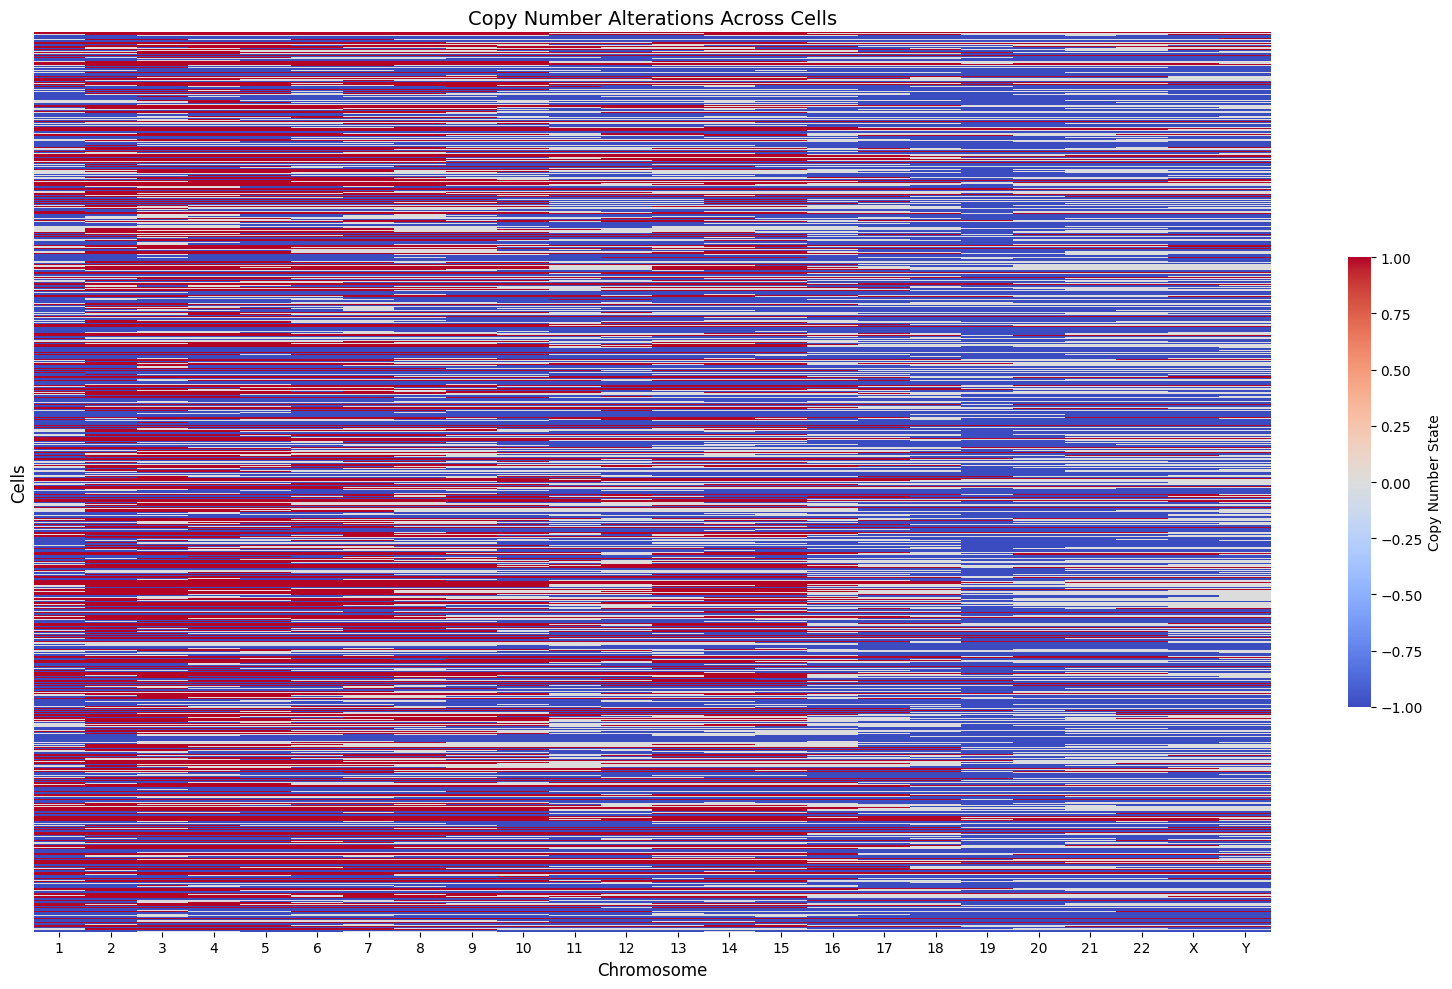

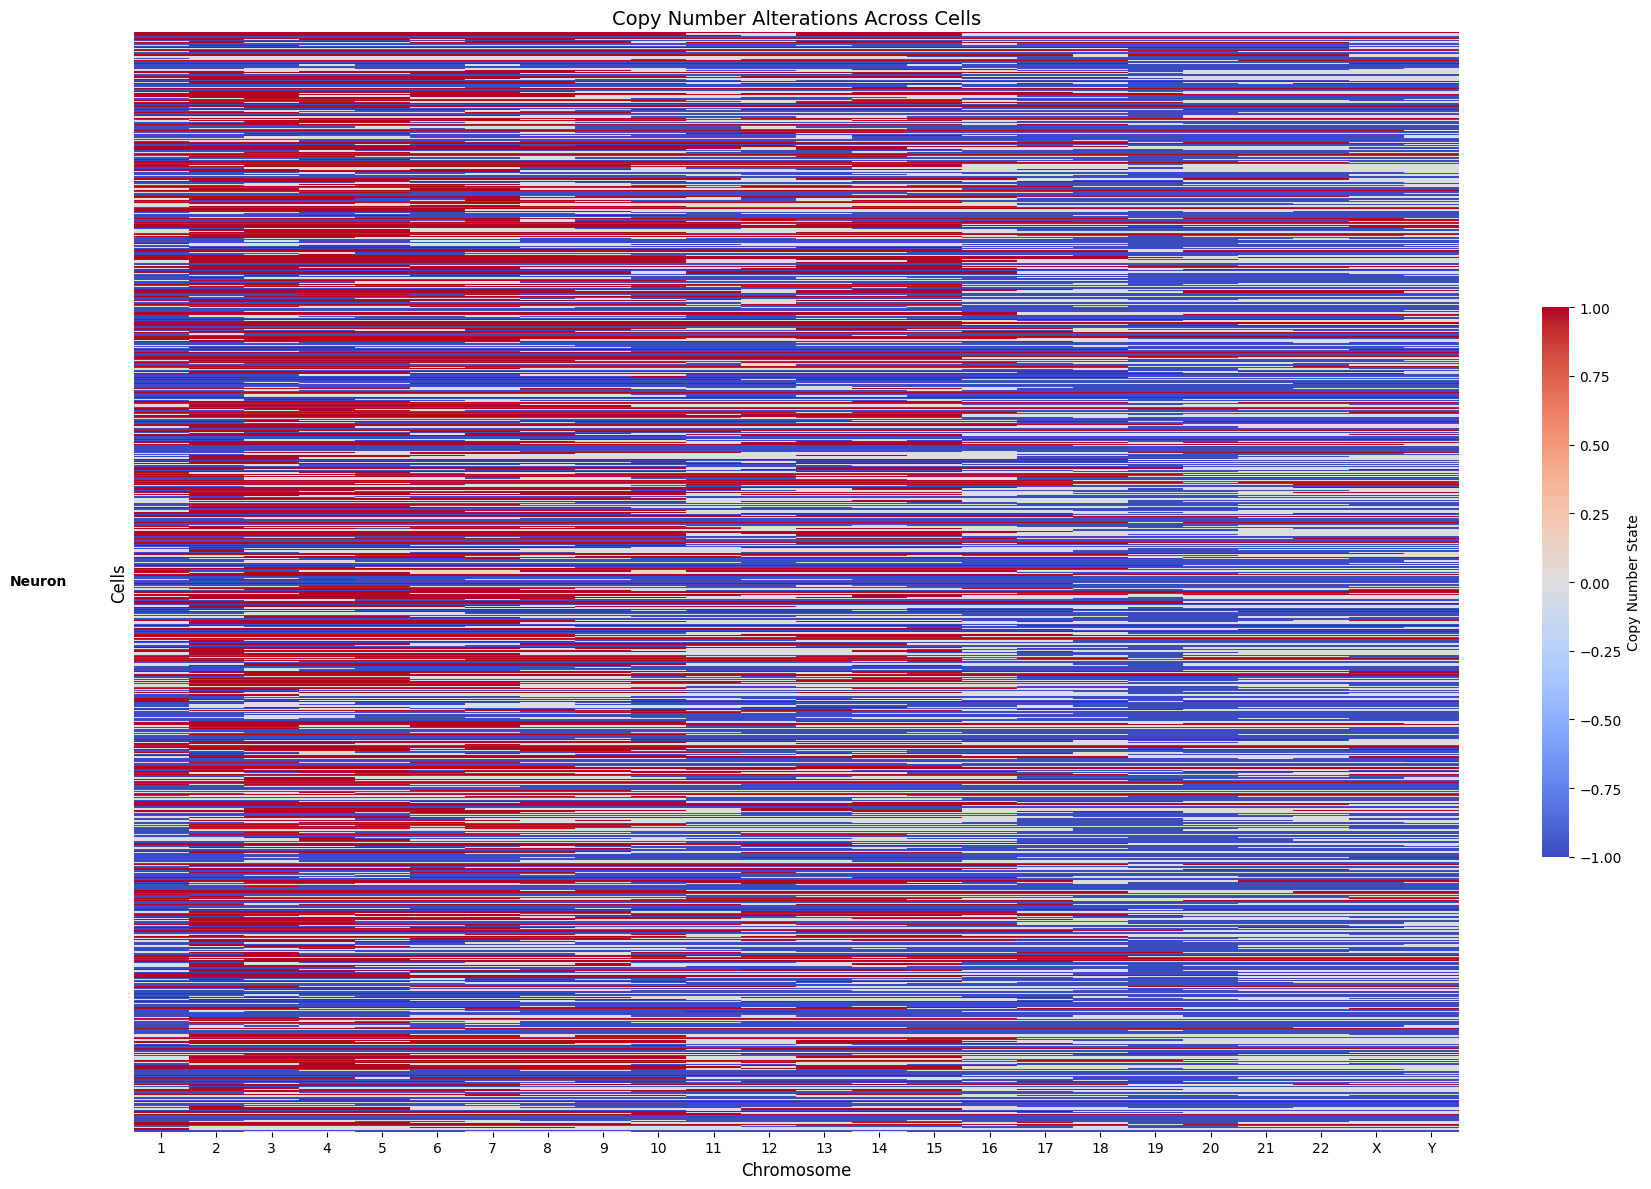

In [ ]:
# Basic usage
fig, ax, cna_matrix = plot_cna_heatmap(neurons_annot_with_calls, cna_col='cnv_regions')

# If you want to group by cell type or cluster
if 'cell_type' in neurons_annot_with_calls.obs.columns:
    fig, ax, cna_matrix = plot_cna_heatmap(
        neurons_annot_with_calls,
        cna_col='cnv_regions',
        group_by='cell_type',
        figsize=(18, 12)
    )

# Save the figure
fig.savefig('cna_task3_test2_neurons_heatmap.png', dpi=300, bbox_inches='tight')

# **Comparison to Known CNVs**


Previous literature has identified the following copy number alterations in iPSC neurons:
- **Chr3p14 duplication**
  - Duplicates the FHIT and PTPRB genes
Larger than initially predicted by SNP array


- **Chr6p22 deletion**
  - Deletes the entire DTNBP1 gene
  - Deletes 11 out of 18 coding exons of JARID2
  - Associated with neurodevelopmental disorders


- **Chr9q33 deletion**
  - Deletes exon 20 of ASTN2 and its antisense gene (ASTN2-AS1)
  - Likely arose from Alu/Alu mediated genomic rearrangement


- **Reference**
  - Gracia-Diaz, Carolina et al. “KOLF2.1J iPSCs carry CNVs associated with neurodevelopmental disorders.” Cell stem cell vol. 31,3 (2024): 288-289. doi:10.1016/j.stem.2024.02.007
  - https://pmc.ncbi.nlm.nih.gov/articles/PMC11857058/

In [ ]:
# Chr3p14 duplication (FHIT and PTPRB genes)
fhit_entries = neurons_annot_with_calls.var[neurons_annot_with_calls.var.index.str.contains('FHIT')]
ptprb_entries = neurons_annot_with_calls.var[neurons_annot_with_calls.var.index.str.contains('PTPRB')]
# Chr6p22 deletion (DTNBP1 and JARID2 genes)
dtnbp1_entries = neurons_annot_with_calls.var[neurons_annot_with_calls.var.index.str.contains('DTNBP1')]
jarid2_entries = neurons_annot_with_calls.var[neurons_annot_with_calls.var.index.str.contains('JARID2')]
# Chr9q33 deletion (ASTN2 gene)
astn2_entries = neurons_annot_with_calls.var[neurons_annot_with_calls.var.index.str.contains('ASTN2')]

display(fhit_entries)
display(ptprb_entries)
display(dtnbp1_entries)
display(jarid2_entries)
display(astn2_entries)


,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm,chromosome,start,end,genomic_pos
FHIT,False,20798,1.753241,47.855083,69928.0,20203,False,1.519738,1.813602,-0.680694,3,59747277,61251459,59747277-61251459


,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm,chromosome,start,end,genomic_pos
PTPRB,False,863,0.024821,97.836279,990.0,744,False,0.050865,1.436004,0.08825,12,70515870,70637440,70515870-70637440


,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm,chromosome,start,end,genomic_pos
DTNBP1,False,4045,0.123756,89.858343,4936.0,3709,True,0.260693,1.530589,0.395309,6,15522807,15663058,15522807-15663058


,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm,chromosome,start,end,genomic_pos
JARID2,False,14021,0.683465,64.846433,27260.0,13565,False,0.927112,1.558404,-0.550966,6,15246069,15522042,15246069-15522042
JARID2-AS1,False,32,0.000802,99.919769,32.0,26,False,0.001822,1.526759,0.382877,6,15247815,15248634,15247815-15248634


,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm,chromosome,start,end,genomic_pos
ASTN2,False,11431,0.630914,71.340103,25164.0,10948,True,0.837211,1.802493,0.637483,9,116423112,117415070,116423112-117415070
ASTN2-AS1,False,1583,0.051398,96.031089,2050.0,1394,False,0.092366,1.439197,0.098616,9,116504283,116564034,116504283-116564034


In [ ]:
known_cnas = [
    # Chr3p14 duplication (FHIT and PTPRB genes)
    {'type': 'gain', 'chr': str(fhit_entries['chromosome'].iloc[0]), 'start': int(fhit_entries['start'].iloc[0]), 'end': int(fhit_entries['end'].iloc[0])},
    {'type': 'gain', 'chr': str(ptprb_entries['chromosome'].iloc[0]), 'start': int(ptprb_entries['start'].iloc[0]), 'end': int(ptprb_entries['end'].iloc[0])},

    # Chr6p22 deletion (DTNBP1 and JARID2 genes)
    {'type': 'loss', 'chr': str(dtnbp1_entries['chromosome'].iloc[0]), 'start': int(dtnbp1_entries['start'].iloc[0]), 'end': int(dtnbp1_entries['end'].iloc[0])},
    {'type': 'loss', 'chr': str(jarid2_entries['chromosome'].iloc[0]), 'start': int(jarid2_entries['start'].iloc[0]), 'end': int(jarid2_entries['end'].iloc[0])},

    # Chr9q33 deletion (ASTN2 gene)
    {'type': 'loss', 'chr': str(astn2_entries['chromosome'].iloc[0]), 'start': int(astn2_entries['start'].iloc[0]), 'end': int(astn2_entries['end'].iloc[0])}
]
known_cnas

[{'type': 'gain', 'chr': '3', 'start': 59747277, 'end': 61251459},
 {'type': 'gain', 'chr': '12', 'start': 70515870, 'end': 70637440},
 {'type': 'loss', 'chr': '6', 'start': 15522807, 'end': 15663058},
 {'type': 'loss', 'chr': '6', 'start': 15246069, 'end': 15522042},
 {'type': 'loss', 'chr': '9', 'start': 116423112, 'end': 117415070}]

In [ ]:
def compare_with_known_cnas(
    adata,
    known_cnas,
    cna_col='cnv_regions',
    overlap_threshold=0.30,
    return_dataframes=True  # Added parameter
):
    """
    Compare detected CNAs in an AnnData object with a list of known CNAs.

    Parameters
    ----------
    adata : AnnData
        AnnData object with CNA calls
    known_cnas : list of dict
        List of known CNAs with keys 'type', 'chr', 'start', 'end'
    cna_col : str, default='cnv_regions'
        Column in adata.obs containing CNA region annotations
    overlap_threshold : float, default=0.3
        Minimum fraction of overlap required to consider a match
    return_dataframes : bool, default=True
        Whether to return R-compatible dataframes for the results

    Returns
    -------
    dict
        Dictionary containing summary statistics, match information, and (if return_dataframes=True)
        pandas DataFrames formatted for export to R
    """
    import pandas as pd
    import numpy as np
    import re

    if cna_col not in adata.obs.columns:
        raise ValueError(f"Column '{cna_col}' not found in adata.obs")

    # Process known CNAs
    known_cnas_df = pd.DataFrame(known_cnas)

    # Extract all detected CNAs
    detected_cnas = []

    for cell_id, cna_str in adata.obs[cna_col].items():
        if pd.isna(cna_str) or cna_str == "":
            continue

        # Split into individual CNA events
        cna_events = cna_str.split(", ")

        for event in cna_events:
            # Parse the event string
            match = re.match(r"([^:]+):(\d+)-(\d+)\s+\(([a-z]+)\)", event)
            if not match:
                continue

            chrom = match.group(1)
            start = int(match.group(2))
            end = int(match.group(3))
            state = match.group(4)

            # Convert state to type (Amp/Del)
            cna_type = "Amp" if state == "gain" else "Del" if state == "loss" else "Neutral"

            detected_cnas.append({
                'cell_id': cell_id,
                'chr': chrom,
                'start': start,
                'end': end,
                'type': cna_type,
                'event': event
            })

    if not detected_cnas:
        print("No CNAs detected in the dataset")
        return {'matches': []}

    # Convert to DataFrame for easier processing
    detected_df = pd.DataFrame(detected_cnas)

    # Find matches between known and detected CNAs
    matches = []

    for _, known in known_cnas_df.iterrows():
        k_chr = str(known['chr'])
        k_start = float(known['start'])
        k_end = float(known['end'])
        k_type = known['type']

        # Find matching chromosome and type in detected CNAs
        matching_events = detected_df[(detected_df['chr'] == k_chr) &
                                      (detected_df['type'] == k_type)]

        for _, detected in matching_events.iterrows():
            d_start = detected['start']
            d_end = detected['end']

            # Calculate overlap
            overlap_start = max(k_start, d_start)
            overlap_end = min(k_end, d_end)

            if overlap_end > overlap_start:  # There is overlap
                overlap_length = overlap_end - overlap_start
                k_length = k_end - k_start
                d_length = d_end - d_start

                # Calculate overlap fractions
                k_overlap_frac = overlap_length / k_length
                d_overlap_frac = overlap_length / d_length

                # Consider a match if overlap is sufficient
                if k_overlap_frac >= overlap_threshold or d_overlap_frac >= overlap_threshold:
                    matches.append({
                        'cell_id': detected['cell_id'],
                        'known_chr': k_chr,
                        'known_start': k_start,
                        'known_end': k_end,
                        'known_type': k_type,
                        'detected_chr': detected['chr'],
                        'detected_start': d_start,
                        'detected_end': d_end,
                        'detected_type': detected['type'],
                        'overlap_fraction': max(k_overlap_frac, d_overlap_frac),
                        'detected_event': detected['event']
                    })

    # Summarize results
    results = {}

    if matches:
        matches_df = pd.DataFrame(matches)
        results['matches'] = matches

        # Count unique known CNAs that were matched
        unique_known_matches = matches_df[['known_chr', 'known_start', 'known_end', 'known_type']].drop_duplicates()

        # Count cells with each known CNA
        known_cna_cell_counts = {}
        for _, known in unique_known_matches.iterrows():
            key = f"{known['known_type']} {known['known_chr']} {known['known_start']}-{known['known_end']}"
            cells = matches_df[
                (matches_df['known_chr'] == known['known_chr']) &
                (matches_df['known_start'] == known['known_start']) &
                (matches_df['known_end'] == known['known_end']) &
                (matches_df['known_type'] == known['known_type'])
            ]['cell_id'].unique()
            known_cna_cell_counts[key] = len(cells)

        # Print summary
        print(f"CNA Match Summary:")
        print(f"  Total known CNAs: {len(known_cnas_df)}")
        print(f"  Known CNAs detected: {len(unique_known_matches)} ({len(unique_known_matches)/len(known_cnas_df)*100:.1f}%)")
        print(f"  Cells with at least one known CNA: {matches_df['cell_id'].nunique()}")

        print("\nDetailed matches:")
        for cna, cell_count in sorted(known_cna_cell_counts.items(), key=lambda x: x[1], reverse=True):
            print(f"  {cna}: found in {cell_count} cells")

        results.update({
            'matched_known_count': len(unique_known_matches),
            'total_known_count': len(known_cnas_df),
            'cells_with_matches': matches_df['cell_id'].nunique(),
            'known_cna_cell_counts': known_cna_cell_counts
        })

        # Create R-compatible dataframes if requested
        if return_dataframes:
            # 1. CNA Match Summary by Region dataframe
            cna_by_region_data = []
            for key, count in known_cna_cell_counts.items():
                parts = key.split()
                cna_type = parts[0]
                chrom = parts[1]
                pos = parts[2].split('-')
                start = float(pos[0])
                end = float(pos[1])

                # Calculate percentage of cells with this CNA
                percentage = (count / matches_df['cell_id'].nunique()) * 100

                cna_by_region_data.append({
                    'Type': cna_type,
                    'Chromosome': chrom,
                    'Start_Position': start,
                    'End_Position': end,
                    'Cells_Detected': count,
                    'Percentage of Cells with CNA': round(percentage, 1)
                })

            # Create sorted dataframe
            results['cna_by_region_df'] = pd.DataFrame(cna_by_region_data).sort_values(
                by='Cells_Detected', ascending=False
            ).reset_index(drop=True)

            # 2. CNA Match Summary Overall dataframe
            results['cna_summary_df'] = pd.DataFrame({
                'Metric': [
                    'Total known CNAs',
                    'Known CNAs detected',
                    'Detection rate',
                    'Total cells with at least one known CNA',
                    'Total amplification (Amp) regions',
                    'Total deletion (Del) regions',
                    'Most common CNA',
                    'Least common CNA'
                ],
                'Value': [
                    str(len(known_cnas_df)),
                    str(len(unique_known_matches)),
                    f"{(len(unique_known_matches)/len(known_cnas_df)*100):.1f}%",
                    str(matches_df['cell_id'].nunique()),
                    str(len(results['cna_by_region_df'][results['cna_by_region_df']['Type'] == 'Amp'])),
                    str(len(results['cna_by_region_df'][results['cna_by_region_df']['Type'] == 'Del'])),
                    f"{results['cna_by_region_df'].iloc[0]['Type']} on Chr {results['cna_by_region_df'].iloc[0]['Chromosome']} ({results['cna_by_region_df'].iloc[0]['Cells_Detected']} cells)",
                    f"{results['cna_by_region_df'].iloc[-1]['Type']} on Chr {results['cna_by_region_df'].iloc[-1]['Chromosome']} ({results['cna_by_region_df'].iloc[-1]['Cells_Detected']} cells)"
                ]
            })

            # 3. CNA Detection by Chromosome and Type
            amp_matches = matches_df[matches_df['known_type'] == 'Amp'].groupby('known_chr')['cell_id'].nunique().reset_index()
            amp_matches.columns = ['Chromosome', 'Cells_Detected']
            amp_matches['Type'] = 'Amp'

            del_matches = matches_df[matches_df['known_type'] == 'Del'].groupby('known_chr')['cell_id'].nunique().reset_index()
            del_matches.columns = ['Chromosome', 'Cells_Detected']
            del_matches['Type'] = 'Del'

            results['cna_by_chr_type_df'] = pd.concat([amp_matches, del_matches]).reset_index(drop=True)

    else:
        print("No matches found between detected CNAs and known CNAs")
        results['matches'] = []

        if return_dataframes:
            # Create empty dataframes
            results['cna_by_region_df'] = pd.DataFrame(columns=[
                'Type', 'Chromosome', 'Start_Position', 'End_Position', 'Cells_Detected', 'Percentage'
            ])
            results['cna_summary_df'] = pd.DataFrame(columns=['Metric', 'Value'])
            results['cna_by_chr_type_df'] = pd.DataFrame(columns=['Type', 'Chromosome', 'Cells_Detected'])

    return results

In [ ]:
# Run the comparison
results = compare_with_known_cnas(neurons_annot_with_calls, known_cnas, cna_col='cnv_regions')

# The dataframes are in the results dictionary
cna_by_region_df = results['cna_by_region_df']
cna_summary_df = results['cna_summary_df']
cna_by_chr_type_df = results['cna_by_chr_type_df']

No matches found between detected CNAs and known CNAs


In [ ]:
# Since no matches found, we'll manually enter data into the dataframe to show how there is 0 match
import pandas as pd

# Create the dataframe from the known_cnas dictionary
cna_by_region_df = pd.DataFrame({
    'Type': [
        'Amp' if known_cnas[0]['type'] == 'gain' else 'Del',  # FHIT
        'Amp' if known_cnas[1]['type'] == 'gain' else 'Del',  # PTPRB
        'Amp' if known_cnas[2]['type'] == 'gain' else 'Del',  # DTNBP1
        'Amp' if known_cnas[3]['type'] == 'gain' else 'Del',  # JARID2
        'Amp' if known_cnas[4]['type'] == 'gain' else 'Del'   # ASTN2
    ],
    'Chromosome': [
        known_cnas[0]['chr'],  # FHIT
        known_cnas[1]['chr'],  # PTPRB
        known_cnas[2]['chr'],  # DTNBP1
        known_cnas[3]['chr'],  # JARID2
        known_cnas[4]['chr']   # ASTN2
    ],
    'Start_Position': [
        known_cnas[0]['start'],  # FHIT
        known_cnas[1]['start'],  # PTPRB
        known_cnas[2]['start'],  # DTNBP1
        known_cnas[3]['start'],  # JARID2
        known_cnas[4]['start']   # ASTN2
    ],
    'End_Position': [
        known_cnas[0]['end'],  # FHIT
        known_cnas[1]['end'],  # PTPRB
        known_cnas[2]['end'],  # DTNBP1
        known_cnas[3]['end'],  # JARID2
        known_cnas[4]['end']   # ASTN2
    ],
    'Cells_Detected': [0, 0, 0, 0, 0],
    'Percentage': [0.0, 0.0, 0.0, 0.0, 0.0]
})

# Display the dataframe
cna_by_region_df

,Type,Chromosome,Start_Position,End_Position,Cells_Detected,Percentage
0,Amp,3,59747277,61251459,0,0.0
1,Amp,12,70515870,70637440,0,0.0
2,Del,6,15522807,15663058,0,0.0
3,Del,6,15246069,15522042,0,0.0
4,Del,9,116423112,117415070,0,0.0
